In [3]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d,lib.cnmem=0"%(random.randint(0,3))
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge, Conv2D
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
import cPickle, random, sys, keras
from keras.models import Model
from IPython import display

sys.path.append("../common")
from keras.utils import np_utils
from tqdm import tqdm

Using TensorFlow backend.


In [5]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

# Load data

## LiDAR

In [6]:
data_len = 1000

In [11]:
lidar_path = '../../../../research_data/datasets/kitti/kitti-yolo-100m-res-0.1/npy'
data = np.load(lidar_path + '/outfile_9999.npy')
import os

'''
for root, dirs, files in os.walk(lidar_path):
    for file in files:        
        if file.endswith((".npy")):
            print file
'''

files = sorted(os.listdir(lidar_path))
lidar_data = []
i = 0
for file in files:
    if file.endswith((".npy")):
        data = np.load(lidar_path + '/' + file)
        data = data.astype(np.float64)
        lidar_data.append(data)
        i+=1
        if(i==data_len):
            break
lidar_data = np.array(lidar_data)        
# Add the channel dim
lidar_data = np.expand_dims(lidar_data, axis=1)

In [12]:
lidar_data.shape

(1000, 1, 1000, 300)

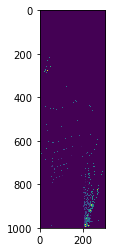

In [9]:
plt.imshow(lidar_data[100])

## Camera

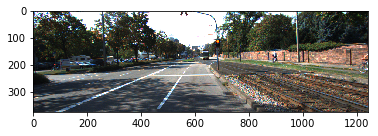

In [7]:

import matplotlib.image as mpimg
path_to_file = '../../../../research_data/datasets/kitti/rgb_images'
img = '100.png'
plt.imshow(mpimg.imread(path_to_file + '/' + img))

In [8]:
i = mpimg.imread(path_to_file + '/' + img)

In [9]:
i.shape

(375, 1242, 3)

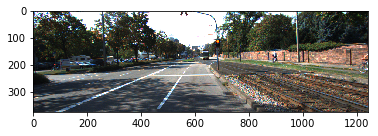

In [10]:
plt.imshow(i)

In [ ]:
'''
from PIL import Image
path_to_file = '../../../datasets/kitti/rgb_images'
im_frame = Image.open(path_to_file + '/0.png')
np_frame = np.array(im_frame.getdata())
'''

In [13]:

import matplotlib.image as mpimg
camera_path = '../../../../research_data/datasets/kitti/rgb_images'
files = sorted(os.listdir(camera_path))
camera_data = []
i = 0
for file in files:
    if file.endswith((".png")):        
        #im_frame = Image.open(camera_path + '/' + file)
        im_frame = mpimg.imread(camera_path + '/' + file)
        im_frame /= 255
        camera_data.append(im_frame)
        i+=1
        if(i==data_len):
            break
camera_data = np.array(camera_data) 
# Make channel first
camera_data = np.array(np.transpose(camera_data, (0, 3, 1, 2)))

In [14]:
camera_data.shape

(1000, 3, 375, 1242)

# Combine both LiDAR and Images

In [15]:
import pandas as pd
camera_data = list(camera_data)
lidar_data = list(lidar_data)

df = pd.DataFrame({'images':camera_data, 'lidar':lidar_data})

## Train/test data

In [16]:
from sklearn.model_selection import train_test_split
random_state = 42
test_size = 0.1
# the data, shuffled and split between train and test sets

(X_train, X_test) = train_test_split(df, test_size=test_size, random_state=random_state, shuffle=True)


# GAN

In [17]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [18]:
#shp = X_train.shape[1:]
#print shp

dropout_rate = 0.25
# Optim

opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)
#opt = Adam(lr=1e-3)
#opt = Adamax(lr=1e-4)
#opt = Adam(lr=0.0002)
#opt = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-08)


# Build Generative model ...
nch = 20
#(img_L, img_W) = df['images'][0].shape
(ch, lidar_img_L, lidar_img_W) = df['lidar'][0].shape
g_input = Input(shape=(df['images'][0].shape))
H = Flatten()(g_input)
H = Dense(nch*lidar_img_L/2*lidar_img_W/2, init='glorot_normal')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape( [nch, lidar_img_L/2, lidar_img_W/2] )(H)
H = UpSampling2D(size=(2, 2), data_format='channels_first')(H)
H = Conv2D(nch/2, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(nch/4, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(1, (1, 1), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


# Build Discriminative model ...
d_input = Input(shape=df['lidar'][0].shape)
#d_input = Input(shape=(1, df['lidar'][0].shape[0], df['lidar'][0].shape[1]))

#H = keras.backend.expand_dims(d_input, axis=1)
#print(H.shape)
H = Conv2D(256, (5, 5), data_format='channels_first', subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Conv2D(512, (5, 5), data_format='channels_first', subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

# Freeze weights in the discriminator for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
make_trainable(discriminator, False)
# Build stacked GAN model
gan_input = Input(shape=df['images'][0].shape)
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()


/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1500000, kernel_initializer="glorot_normal")`
/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (3, 3), padding="same", kernel_initializer="glorot_uniform", data_format="channels_first")`
/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (3, 3), padding="same", kernel_initializer="glorot_uniform", data_format="channels_first")`
/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), padding="same", kernel_initializer="glorot_uniform", data_format="channels_first")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 375, 1242)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1397250)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 1500000)           2095876500
_________________________________________________________________
batch_normalization_1 (Batch (None, 1500000)           6000000   
_________________________________________________________________
activation_1 (Activation)    (None, 1500000)           0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 20, 500, 150)      0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 20, 1000, 300)     0         
__________

/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), padding="same", strides=(2, 2), activation="relu", data_format="channels_first")`
/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (5, 5), padding="same", strides=(2, 2), activation="relu", data_format="channels_first")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3, 375, 1242)      0         
_________________________________________________________________
model_1 (Model)              (None, 1, 1000, 300)      2095882504
_________________________________________________________________
model_2 (Model)              (None, 2)                 2460884738
Total params: 2,098,343,389,409
Trainable params: 2,095,879,503,471
Non-trainable params: 2,463,885,938
_________________________________________________________________


In [32]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

In [33]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
#ntrain = 900
#trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
#XT = X_train

# Pre-train the discriminator network ...
#noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
BATCH_SIZE = 10
#XT = X_train.sample(n=BATCH_SIZE, random_state=random_state)
#print(XT.shape)
train_imgs = np.stack(np.array(X_train['images']).flat)
#images_gen = np.array(np.transpose(train_imgs, (0, 3, 1, 2)))
images_gen = train_imgs
#print(images_gen.shape)
train_lidar = np.stack(np.array(X_train['lidar']).flat)
#train_lidar = np.expand_dims(train_lidar, axis=1)
#generator.fit(images_gen, train_lidar, nb_epoch=100, batch_size=BATCH_SIZE)
generated_lidar = generator.predict(images_gen)

print(train_lidar.shape)
X = np.concatenate((np.array(X_train['lidar']), generated_lidar))
n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

make_trainable(discriminator,True)
discriminator.fit(X,y, nb_epoch=100, batch_size=BATCH_SIZE)
y_hat = discriminator.predict(X)
make_trainable(discriminator,False)
GAN.fit(images_gen, train_lidar, nb_epoch=100, batch_size=BATCH_SIZE)


In [84]:
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print "Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot)

NameError: name 'y_hat' is not defined

In [83]:
# set up loss storage vector
losses = {"d":[], "g":[]}

In [ ]:
make_trainable(discriminator,True)

In [4]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        #XT = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE)]    
        XT = X_train.sample(n=BATCH_SIZE, random_state=random_state)
        #lidar_batch = np.array(XT['lidar'])
        train_lidar = np.stack(np.array(X_train['lidar']).flat)
        #noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        #images_gen = np.array(XT['images'])
        train_imgs = np.stack(np.array(XT['images']).flat)
        #images_gen = np.array(np.transpose(train_imgs, (0, 3, 1, 2)))# Channels first
        #generator.train_on_batch(images_gen, train_lidar, nb_epoch=100, batch_size=BATCH_SIZE)
        generated_lidar = generator.predict(images_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((train_lidar, generated_lidar))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        #make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        #noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        #make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(images_gen, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()
        

In [86]:
train_for_n(nb_epoch=6000, plt_frq=25,BATCH_SIZE=32)

  0%|          | 0/6000 [00:00<?, ?it/s]

FailedPreconditionError: Attempting to use uninitialized value dense_12/kernel
	 [[Node: dense_12/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@dense_12/kernel"], _device="/job:localhost/replica:0/task:0/gpu:0"](dense_12/kernel)]]
	 [[Node: activation_26/Sigmoid/_15 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_333_activation_26/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'dense_12/kernel/read', defined at:
  File "/root/anaconda3/envs/DL2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/root/anaconda3/envs/DL2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-f563fedbc447>", line 21, in <module>
    H = Dense(nch*lidar_img_L/2*lidar_img_W/2, init='glorot_normal')(H)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/keras/engine/topology.py", line 569, in __call__
    self.build(input_shapes[0])
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/keras/layers/core.py", line 825, in build
    constraint=self.kernel_constraint)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/keras/engine/topology.py", line 391, in add_weight
    weight = K.variable(initializer(shape), dtype=dtype, name=name)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 321, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 319, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1303, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/root/anaconda3/envs/DL2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value dense_12/kernel
	 [[Node: dense_12/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@dense_12/kernel"], _device="/job:localhost/replica:0/task:0/gpu:0"](dense_12/kernel)]]
	 [[Node: activation_26/Sigmoid/_15 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_333_activation_26/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
opt.lr= 1e-5
dopt.lr = 1e-4
train_for_n(nb_epoch=2000, plt_frq=25,BATCH_SIZE=32)

In [ ]:
opt.lr = 1e-6
dopt.lr = 1e-5
train_for_n(nb_epoch=2000, plt_frq=25,BATCH_SIZE=32)

In [ ]:
plot_loss(losses)

In [ ]:
plot_gen(25,(5,5),(12,12))

In [ ]:
def plot_real(n_ex=16,dim=(4,4), figsize=(10,10) ):
    
    idx = np.random.randint(0,X_train.shape[0],n_ex)
    generated_images = X_train[idx,:,:,:]

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()



In [ ]:
plot_real()